In [3]:
import numpy as np

In [4]:
def center(X, cluster):
    nn, mm = X.shape
    ccc = []
    for jj in range(mm):
        zz = np.array(X[:, jj])
        zc = zz[cluster]
        ccc.append(np.mean(zc))
    
    return np.array(ccc)

In [5]:
def dist(X, remains, range_in, a):
    nn, mm = X.shape
    rr = len(remains)
    distan = np.zeros(rr)
    
    for jj in range(mm):
        z = X[:, jj]
        zz = z[remains]
        y = zz - a[jj]
        y = y / range_in[jj]
        yy = np.multiply(y, y)
        distan += yy
        
    return distan

In [6]:
def distm(X, remains, range_in, a):
    nn, mm = X.shape
    rr = len(remains)
    z = X[remains, :]
    az = np.tile(a, (rr, 1))
    rz = np.tile(range_in, (rr, 1))
    dz = np.divide(z - az, rz)
    ddz = np.multiply(dz, dz)
    
    if mm > 1:
        di = sum(ddz.T)
    else:
        di = ddz.T
    
    return np.array(di.T)

In [7]:
def separc(X0, remains, range_in, a, b):
    dista = distm(X0, remains, range_in, a)
    distb = distm(X0, remains, range_in, b)
    clus = dista < distb
    cluster = remains[clus]
    return cluster

In [8]:
def stand(X):
    nn, mm = X.shape
    
    print('Hit 1 for NO normalization or just "enter"')
    sst = input()
    
    me = []
    mmax = []
    mmin = []
    range_in = []
    
    for jj in range(mm):
        z = X[:, jj]
        me.append(np.mean(z))
        mmax.append(np.max(z))
        mmin.append(np.min(z))
        
        if sst == "1":
            range_in.append(1)
        else:
            range_in.append(mmax[jj] - mmin[jj])
        
        if range_in[jj] == 0:
            print('Variable number' + str(jj) + '  is constant!')
            range_in[jj] = 1
    
    return me, range_in, mmin, mmax, sst

In [9]:
def anpat(X, remains, range_in, centroid, me):
    count = 0
    key = 1
    
    while key == 1:
        cluster = separc(X, remains, range_in, centroid, me)
        if len(cluster) != 0:
            newcenter = center(X, cluster)
        else:
            newcenter = centroid
        if not np.array_equal(centroid, newcenter):
            centroid = newcenter
        else:
            key = 0
    
    return cluster, centroid

In [10]:
def anomalous(X, me, range_in, D):
    nn, mm = X.shape
    remains = np.array([*range(nn)])
    number = -1
    ancl = dict()
    
    while len(remains) > 0:
        distance = dist(X, remains, range_in, me)
        
        ind = np.argmax(distance)
        index = remains[ind]
        centroid = X[index, :]
        
        number += 1
        cluster, centroid = anpat(X, remains, range_in, centroid, me)
        ancl[(number, 1)] = cluster
        
        censtand = np.divide(centroid - me, range_in)
        dD = censtand * censtand.T * len(cluster) * 100 / D
        ancl[(number, 2)] = censtand
        ancl[(number, 3)] = dD
        remains = np.array(list(set(remains) - set(cluster)))
    
    return ancl

In [11]:
def ceupdate(X, labelc):
    K = max(labelc)
    centres = []
    
    for kk in range(K + 1):
        clk = np.where(labelc == kk)[0]
        
        nc = len(clk)
        elemk = X[clk, :]

        if nc == 0:
            print('At index ' + str(kk) + 'cluster is empty ')
        elif nc == 1:
            centres.append(elemk)
        else:
            centres.append(np.mean(elemk, axis=0))
         
    centres = np.array(centres)
    return centres

In [12]:
def clusterupdate(Y, cent):
    K, m = cent.shape
    N, m = Y.shape
    disto = []
    
    for k in range(K):
        cc = cent[k, :]
        Ck = np.tile(cc, (N, 1))
        dif = Y - Ck
        
        ddif = np.multiply(dif, dif)
        disto.append(np.array(np.sum(ddif, axis=1)))
        
    aa = np.amin(disto, axis=0)
    bb = np.argmin(disto, axis=0)
    
    wc = sum(aa)
    labelc = bb
    
    return labelc, wc

In [13]:
def k_means(Y, cent, range_in, me):
    N, m = Y.shape
    K, m1 = cent.shape
    flag = 0
    membership = np.zeros((N, 1))
    clusters = dict()
    
    dd = sum(sum(np.multiply(Y, Y)))
    
    while flag == 0:
        labelc, wc = clusterupdate(Y, cent)
        
        if np.array_equal(labelc, membership):
            flag = 1
            centre = cent
            w = wc
        else:
            cent = ceupdate(Y, labelc)
            membership = labelc
    
    centrestand = centre
    centrereal = []
    
    for ii in range(K):
        centrereal.append(np.multiply(centre[ii, :], range_in) + me)
    
    wd = w * 100 / dd
    clusters[1] = membership
    clusters[2] = centrestand
    clusters[3] = centrereal
    
    return clusters, wd

In [35]:
def ikmeansb(X, yvar):
    nn, mm = X.shape
    me, range_in, mmin, mmax, sst = stand(X)
    
    sY = (X - me) / range_in
    D = sum(sum(np.multiply(sY, sY)))
    ancl = anomalous(X, me, range_in, D)
    
    print('Input cluster cardinality to discard ')
    threshold = int(input())
    
    b = 3
    aK = int(len(ancl) / b)
    ll = []
    
    for ik in range(aK):
        ll.append(len(ancl[(ik, 1)]))
        
    ll = np.array(ll)
    rl = np.where(ll > threshold)[0]

    cent = []
    
    if len(rl) == 0:
        print('Too great threshold!!!')
    else:
        for ik in range(len(rl)):
            cent.append(ancl[(rl[ik], 2)])
    
    cent = np.array(cent)
    clusters, wd = k_means(sY, cent, range_in, me)
    return clusters, wd, cent

In [19]:
from sklearn.datasets import load_iris

data_in = load_iris()
x_values = data_in.data
clusters, wd, _ = ikmeansb(x_values, [])
print("Clusters:", clusters)
print("wd:", wd)

Hit 1 for NO normalization or just "enter"
1
Input cluster cardinality to discard 
10
Clusters: {1: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2], dtype=int64), 2: array([[ 1.01051282,  0.02292308,  1.95671795,  0.85517949],
       [-0.83733333,  0.364     , -2.29466667, -0.95466667],
       [ 0.04027322, -0.31301639,  0.62985792,  0.23575956]]), 3: [array([6.85384615, 3.07692308, 5.71538462, 2.05384615]), array([5.006, 3.418, 1.464, 0.244]), array([5.88360656, 2.74098361, 4.38852459, 1.43442623])]}
wd: 11.595510652376337


In [23]:
def report(clusters):
    n = max(clusters[1])
    
    for i in range(n + 1):
        print("Cluster", i+1, "(" + str(sum(clusters[1] == i)) + ")")
        print(np.where(clusters[1] == i)[0])
        print("Cluster centroid (real)", clusters[3][i])
        print("Cluster centroid (stand)", clusters[2][i], "\n")

report(clusters)

Cluster 1 (39)
[ 50  52  77 100 102 103 104 105 107 108 109 110 111 112 115 116 117 118
 120 122 124 125 128 129 130 131 132 134 135 136 137 139 140 141 143 144
 145 147 148]
Cluster centroid (real) [6.85384615 3.07692308 5.71538462 2.05384615]
Cluster centroid (stand) [1.01051282 0.02292308 1.95671795 0.85517949] 

Cluster 2 (50)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Cluster centroid (real) [5.006 3.418 1.464 0.244]
Cluster centroid (stand) [-0.83733333  0.364      -2.29466667 -0.95466667] 

Cluster 3 (61)
[ 51  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 101 106 113 114 119 121 123
 126 127 133 138 142 146 149]
Cluster centroid (real) [5.88360656 2.74098361 4.38852459 1.43442623]
Cluster centroid (stand) [ 0.04027322 -0.31301639  0

In [24]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

In [27]:
from numpy import genfromtxt
data = genfromtxt('tripadvisor_review.csv', delimiter=',')
data = data[1:, 1:]

x = data[:,5] # Resorts
y = data[:,4] # Museums

alldata = np.vstack((x, y))

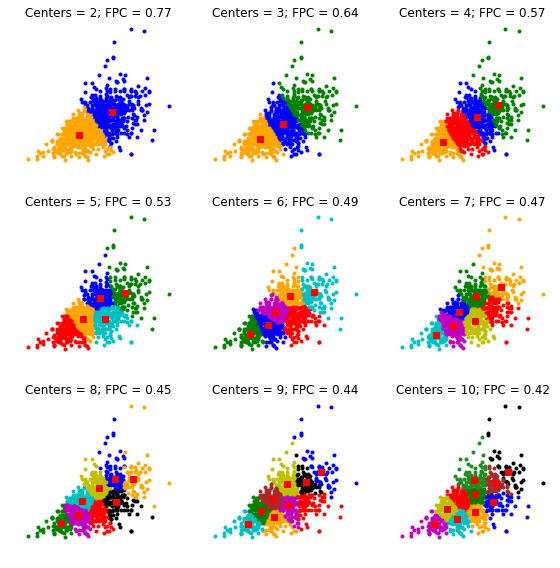

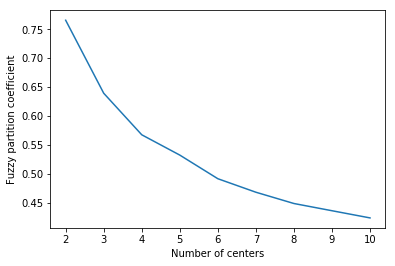

In [26]:
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(x[cluster_membership == j],
                y[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient");

In [36]:
data = genfromtxt('tripadvisor_review.csv', delimiter=',')
data = data[1:, 1:-1]
clusters, wd, cent = ikmeansb(data, [])
print("Clusters:", clusters)
print("wd:", wd)

Hit 1 for NO normalization or just "enter"
1
Input cluster cardinality to discard 
10
Clusters: {1: array([1, 8, 6, 7, 5, 2, 2, 2, 5, 3, 5, 7, 1, 1, 1, 8, 4, 1, 5, 1, 5, 3,
       2, 2, 5, 8, 1, 4, 2, 1, 1, 8, 8, 3, 2, 4, 4, 2, 1, 6, 3, 2, 3, 7,
       7, 6, 2, 4, 7, 1, 3, 1, 3, 4, 2, 2, 1, 2, 1, 5, 1, 6, 2, 2, 6, 6,
       4, 2, 4, 2, 6, 1, 7, 1, 4, 8, 6, 1, 2, 3, 6, 4, 2, 6, 6, 7, 2, 2,
       0, 7, 6, 2, 8, 1, 8, 6, 1, 4, 1, 3, 3, 2, 8, 2, 6, 1, 5, 2, 6, 8,
       7, 4, 7, 4, 1, 3, 4, 3, 4, 4, 8, 3, 8, 6, 5, 2, 2, 4, 4, 2, 4, 5,
       8, 5, 7, 3, 4, 5, 3, 2, 3, 2, 7, 2, 3, 7, 3, 1, 5, 5, 5, 7, 2, 7,
       7, 4, 3, 6, 8, 4, 4, 2, 7, 4, 4, 2, 1, 3, 1, 4, 3, 6, 2, 2, 3, 7,
       3, 4, 3, 2, 2, 5, 5, 4, 1, 3, 3, 6, 5, 2, 1, 1, 6, 3, 3, 2, 4, 5,
       4, 0, 1, 7, 1, 2, 4, 2, 3, 2, 4, 4, 4, 1, 7, 2, 2, 5, 2, 2, 5, 1,
       3, 4, 8, 2, 5, 7, 0, 4, 7, 1, 2, 1, 2, 7, 3, 3, 5, 7, 5, 6, 1, 8,
       4, 7, 2, 4, 6, 0, 6, 3, 5, 2, 1, 1, 7, 7, 2, 0, 6, 5, 5, 5, 6, 8,
       2, 5, 1, 7, 7, 5,

In [34]:
report(clusters)

Cluster 1 (18)
[ 88 199 226 247 257 274 286 372 422 437 592 601 666 694 728 747 829 903]
Cluster centroid (real) [1.02888889 2.00444444 0.57666667 2.18388889 1.17333333 2.05111111
 3.18222222 2.72333333 1.46      ]
Cluster centroid (stand) [ 1.35695011e-01  6.51832200e-01 -4.36639456e-01  1.65138889e+00
  2.33598639e-01  2.08213152e-01  1.28344671e-03 -1.11727891e-01
 -1.09438776e-01] 

Cluster 2 (138)
[  0  12  13  14  17  19  26  29  30  38  49  51  56  58  60  71  73  77
  93  96  98 105 114 147 166 168 184 190 191 200 202 211 219 229 231 240
 252 253 266 272 273 282 290 301 304 307 309 316 318 326 331 341 343 348
 349 371 375 385 401 407 409 415 420 430 458 465 470 475 478 497 498 502
 510 515 517 522 524 537 551 555 560 561 562 566 567 588 598 622 640 654
 655 660 662 665 671 685 717 718 719 733 750 780 781 785 786 790 791 798
 799 802 805 807 814 816 818 819 828 834 835 857 859 860 862 866 883 885
 892 901 907 915 924 925 931 942 951 955 960 963]
Cluster centroid (real) [0.790652

In [86]:
import scipy.spatial

def pairwise_squared_distances(A, B):
    return scipy.spatial.distance.cdist(A, B)**2

def calculate_covariances(x, u, v, m):
    c, n = u.shape
    d = v.shape[1]
    
    um = u**m

    covariances = np.zeros((c, d, d))

    for i in range(c):
        xv = x - v[i]
        uxv = um[i, :, np.newaxis]*xv
        covariances[i] = np.einsum('ni,nj->ij', uxv, xv)/np.sum(um[i])
    
    return covariances

def pc(x, u, v, m):
    c, n = u.shape
    return np.square(u).sum()/n

def npc(x, u, v, m):
    n, c = u.shape
    return 1 - c/(c - 1)*(1 - pc(x, u, v, m))

def xb(x, u, v, m):
    n = x.shape[0]
    c = v.shape[0]

    um = u**m
    
    d2 = pairwise_squared_distances(x, v)
    v2 = pairwise_squared_distances(v, v)
    
    v2[v2 == 0.0] = np.inf

    return np.sum(um.T*d2)/(n*np.min(v2))

def fcm_get_u(x, v, m):
    distances = pairwise_squared_distances(x, v)
    nonzero_distances = np.fmax(distances, np.finfo(np.float64).eps)
    inv_distances = np.reciprocal(nonzero_distances)**(1/(m - 1))
    return inv_distances.T/np.sum(inv_distances, axis=1)

def fcm(x, c, m=2.0, v=None, max_iter=100, error=0.05):
    if v is None: v = x[np.random.randint(x.shape[0], size=c)]
    u = fcm_get_u(x, v, m)
    for iteration in range(max_iter):
        u_old = u
        um = u**m
        v = np.dot(um, x)/np.sum(um, axis=1, keepdims=True)
        u = fcm_get_u(x, v, m)
        if np.linalg.norm(u - u_old) < error: break
    return v

m = 2.0
cs = np.arange(2, 10)

for c in cs:
    v = fcm(data, c)
    print(v.shape)
    print(u.shape)
    u = fcm_get_u(data, v, m)
    print("Number of centers:", c)
    print("Xie Beni Index:", xb(data, u, v, m))
    print("Partition Coefficient:", pc(data, u, v, m))
    print("Normalized Partition Coefficient:", npc(data, u, v, m), "\n")    

(2, 9)
(9, 980)
Number of centers: 2
Xie Beni Index: 0.4695721259853609
Partition Coefficient: 0.6425041722743295
Normalized Partition Coefficient: 0.6421390079967753 

(3, 9)
(2, 980)
Number of centers: 3
Xie Beni Index: 1.6610800455271735
Partition Coefficient: 0.4418901419184907
Normalized Partition Coefficient: 0.44132006034741667 

(4, 9)
(3, 980)
Number of centers: 4
Xie Beni Index: 9.578842971727845
Partition Coefficient: 0.33935347259008364
Normalized Partition Coefficient: 0.3386786548909929 

(5, 9)
(4, 980)
Number of centers: 5
Xie Beni Index: 6.011457092009378
Partition Coefficient: 0.27536749012190864
Normalized Partition Coefficient: 0.27462731391161443 

(6, 9)
(5, 980)
Number of centers: 6
Xie Beni Index: 7.1846941819141135
Partition Coefficient: 0.2305237780352928
Normalized Partition Coefficient: 0.22973779619467516 

(7, 9)
(6, 980)
Number of centers: 7
Xie Beni Index: 9.99893074506724
Partition Coefficient: 0.19693477545177665
Normalized Partition Coefficient: 0.196

In [83]:
ncenters = 9

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data, ncenters, 2, error=0.005, maxiter=1000, init=cent)

print(cntr.shape, u.shape, u0.shape, d.shape, jm, p, fpc)

(9, 980) (9, 9) (9, 9) (9, 9) [1.97789472e+03 3.61057420e+02 2.30164255e+02 1.55522055e+02
 6.31180681e+01 7.73726394e-01 2.30558839e-08] 7 1.0


In [88]:
print("Xie Beni Index:", xb(data, u, cntr, m))
print("Partition Coefficient:", pc(data, u, cntr, m))
print("Normalized Partition Coefficient:", npc(data, u, cntr, m))  

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)